### Finite difference methods (FDM) for the Black-Scholes PDE.

#### 1. Black-Scholes PDE

We begin with the Black-Scholes PDE for the price $V(S, t)$ of a European option:

$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$$

This is a parabolic PDE, similar to the heat equation but with non-constant coefficients. 

One can transform this equation by a simple change of variables:

$$\tau = T - t$$
$$x = \ln(S)$$
$$u(x, \tau) = V(S, t) = V(e^x, T - \tau)$$

B-S equation transforms to:

$$\frac{\partial u}{\partial \tau} = \frac{1}{2} \sigma^2 \frac{\partial^2 u}{\partial x^2} + \left(r - \frac{1}{2} \sigma^2\right) \frac{\partial u}{\partial x} - r u$$

Which resembles the convection-diffusion-reaction form:

$$u_\tau = D u_{xx} + a u_x + b u$$

Where:
- $D = \frac{1}{2} \sigma^2$ (diffusion)
- $a = r - \frac{1}{2} \sigma^2$ (drift)
- $b = -r (decay)$

If we eliminate the $u_x$ and $u$ terms, we get a pure heat equation:

$$u_\tau = D u_{xx}$$

This elimination can be done by choosing appropriate $\alpha$ and $\beta$ for the transformation below:

$$u(x, \tau) = e^{\alpha x + \beta \tau} w(x, \tau)$$

#### 2. Discretization of Black-Scholes PDE

In this project, we will solve Black-Scholes equation directly in terms of $S$.

Firstly, let us discretize the continuous domain:

- Price axis $S \in [0, S_{\text{max}}]$ is divided into $M$ steps
- Time axis $t \in [0, T]$ is divided into $N$ steps

We define:
- $\Delta S = \frac{S_{\text{max}}}{M}$
- $\Delta t = \frac{T}{N}$

Now let:
- $V_i^n$ be the numerical approximation to $V(S_i, t_n)$

Now we can define approximations of partial derivatives (one-sided difference for time derivative!!):

$$\frac{\partial V}{\partial t} \approx \frac{V_i^{n+1} - V_i^n}{\Delta t}$$

$$\frac{\partial V}{\partial S} \approx \frac{V_{i+1}^n - V_{i-1}^n}{2 \Delta S}, \quad \frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1}^n - 2V_i^n + V_{i-1}^n}{\Delta S^2}$$

##### 2.1 Explicit method (Forward in Time)

$$V_i^{n+1} = a_i V_{i-1}^n + b_i V_i^n + c_i V_{i+1}^n$$

Where coefficients:
$$a_i = \frac{1}{2} \Delta t \left( \sigma^2 i^2 - r i \right)$$
$$b_i = 1 - \Delta t \left( \sigma^2 i^2 + r \right) $$
$$c_i = \frac{1}{2} \Delta t \left( \sigma^2 i^2 + r i \right)$$

- It is simple to implement
- Conditionally stable: requires small time steps to avoid instability
- Stability condition: $\Delta t \leq \frac{1}{\sigma^2 M^2}$

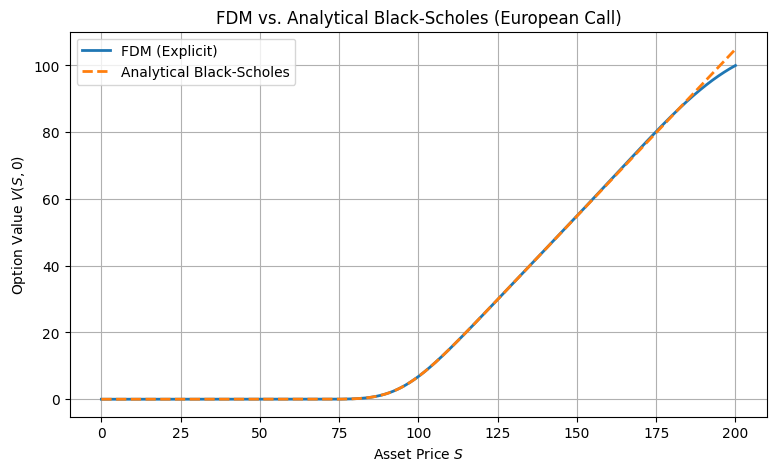

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S_max = 200
K = 100
T = 1.0
r = 0.05
sigma = 0.1

M = 2000
N = 1000000

dS = S_max / M
dt = T / N
S = np.linspace(0, S_max, M+1)
V = np.maximum(S - K, 0)

j = np.arange(1, M)
a = 0.5 * dt * (sigma**2 * j**2 - r * j)
b = 1 - dt * (sigma**2 * j**2 + r)
c = 0.5 * dt * (sigma**2 * j**2 + r * j)

for n in range(N):
    V_old = V.copy()
    V[1:M] = a * V_old[0:M-1] + b * V_old[1:M] + c * V_old[2:M+1]
    V[0] = 0
    V[M] = S_max - K * np.exp(-r * (T - n * dt))

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K + 1e-10) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

V_exact = black_scholes_call(S, K, T, r, sigma)

plt.figure(figsize=(9, 5))
plt.plot(S, V, label='FDM (Explicit)', linewidth=2)
plt.plot(S, V_exact, '--', label='Analytical Black-Scholes', linewidth=2)
plt.xlabel('Asset Price $S$')
plt.ylabel('Option Value $V(S, 0)$')
plt.title('FDM vs. Analytical Black-Scholes (European Call)')
plt.legend()
plt.grid(True)
plt.show()

##### 2.2 Implicit method (Backward in Time)

$$a_i V_{i-1}^{n+1} + (1 + b_i) V_i^{n+1} - c_i V_{i+1}^{n+1} = V_i^n$$

- Requires solving a tridiagonal system at each time step
- Unconditionally stable
- Can be less accurate than Crank-Nicolson